In [ ]:
#importing all the libraries we required to complete the task
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("/content/merged.csv")
print("dataset shape", df.shape)
df.head()

dataset shape (85611, 88)


,Main_Category,Longitude,Latitude,Day,duration,Primary_Vehicle,Secondary_Vehicle,Is_Major_Incident,Advice_A,Advice_B,...,Motorway crew,Emergency services,Transport for NSW,Tow truck,Heavy vehicle tow truck,Incident_Type,Num_Vehicles_Involved,Month,Hour,distance_to_CBD
0,1,151.058,-33.9431,5,39.319950,1,2,0,10,0,...,0,1,0,0,0,0,2,8,19,15.781064
1,0,151.159,-33.8096,6,12.029000,1,9,0,10,134,...,0,0,0,0,0,1,1,8,0,8.323913
2,1,150.875,-33.7344,6,16.956667,1,9,0,26,134,...,0,1,0,0,0,0,1,8,1,34.354983
3,1,150.973,-33.8172,6,42.804117,5,2,0,10,0,...,0,1,1,0,0,0,1,8,1,22.500677
4,1,150.981,-33.7919,6,40.840000,3,4,0,10,134,...,0,0,0,0,0,0,3,8,1,22.753003


In [ ]:
#checking missing data

In [ ]:
# just checking what's missing in the data
null_info = df.isna().sum()
print(null_info)

# filtering out rows where duration is weird or zero
# (accident logs shouldn't have 0 duration anyway)
clean_df = df[df["duration"] > 0]

# resetting index so it doesn't look jumpy
clean_df = clean_df.reset_index(drop=True)

print("after cleaning:", clean_df.shape)

# replacing df with cleaned one so rest of code works
df = clean_df


Main_Category            0
Longitude                0
Latitude                 0
Day                      0
duration                 0
                        ..
Incident_Type            0
Num_Vehicles_Involved    0
Month                    0
Hour                     0
distance_to_CBD          0
Length: 88, dtype: int64
after cleaning: (85519, 88)


In [ ]:
# selecting columns which make sense for the models
# (these are mostly used in the Sydney paper)
cols = [
    "Longitude","Latitude","Day",
    "Primary_V","Secondary","Is_Major_Ir",
    "Affected_L","Traffic_Vol",
    "Actual_Nui","SA2_CODE","SA3_CODE","AREASQKM"
]

# checking if all selected cols are present
use_cols = [c for c in cols if c in df.columns]

print("using", len(use_cols), "features")

X = df[use_cols]
y = df["duration"]


using 3 features


In [ ]:
from sklearn.model_selection import train_test_split

# simple 80/20 split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

x_train.shape, x_test.shape


((68415, 3), (17104, 3))

In [ ]:
# trying Random Forest first
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model = RandomForestRegressor(
    n_estimators=250,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
rf_rmse = mean_squared_error(y_test, rf_pred)

print("RF RMSE:", rf_rmse)


RF RMSE: 988379.7004249452


In [ ]:
import xgboost as xgb

xgb_mod = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.07,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_mod.fit(x_train, y_train)
xgb_pred = xgb_mod.predict(x_test)
xgb_rmse = mean_squared_error(y_test, xgb_pred,)

print("XGB RMSE:", xgb_rmse)


XGB RMSE: 986818.8548811143


In [ ]:
# creating binary label for classification
df["long_flag"] = (df["duration"] >= 30).astype(int)

Y2 = df["long_flag"]
X2 = df[use_cols]

x_tr2, x_te2, y_tr2, y_te2 = train_test_split(
    X2, Y2, test_size=0.2, random_state=42
)


In [ ]:
# PEROFRMANCE EVALUATION OF RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf_cls = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

rf_cls.fit(x_tr2, y_tr2)
rf_cpred = rf_cls.predict(x_te2)

print("RF Acc:", accuracy_score(y_te2, rf_cpred))
print("RF Prec:", precision_score(y_te2, rf_cpred))
print("RF Recall:", recall_score(y_te2, rf_cpred))
print("RF F1:", f1_score(y_te2, rf_cpred))


RF Acc: 0.5416276894293732
RF Prec: 0.52237108190091
RF Recall: 0.5043934586282646
RF F1: 0.5132248851359742


In [ ]:
## PEROFRMANCE EVALUATION OF XG BOOST CLASSIFIER

In [ ]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(
    n_estimators=350,
    max_depth=5,
    learning_rate=0.08,
    subsample=0.9,
    random_state=42
)

xgb_cls.fit(x_tr2, y_tr2)
xgb_cpred = xgb_cls.predict(x_te2)

print("XGB Acc:", accuracy_score(y_te2, xgb_cpred))
print("XGB Prec:", precision_score(y_te2, xgb_cpred))
print("XGB Recall:", recall_score(y_te2, xgb_cpred))
print("XGB F1:", f1_score(y_te2, xgb_cpred))


XGB Acc: 0.5788704396632367
XGB Prec: 0.5667340067340068
XGB Recall: 0.5135464974371491
XGB F1: 0.5388309110698508


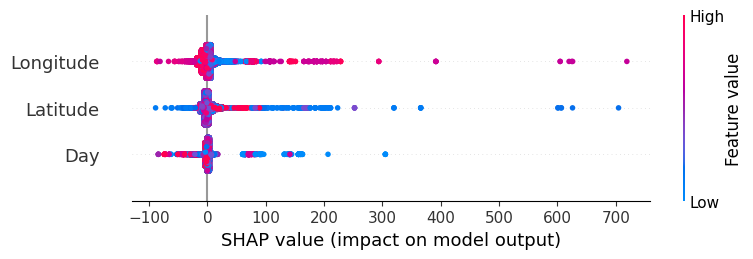

In [ ]:
# shap for explaining the regression XGB (used in the paper)
import shap

expl = shap.TreeExplainer(xgb_mod)
sv = expl.shap_values(x_train)

# summary plot
shap.summary_plot(sv, x_train)


In [ ]:
#Regression Summary

In [ ]:
print("\n==== REGRESSION SUMMARY ====")
print("RF RMSE :", rf_rmse)
print("XGB RMSE:", xgb_rmse)

print("\n==== CLASSIFICATION SUMMARY ====")
print("RF F1  :", f1_score(y_te2, rf_cpred))
print("XGB F1 :", f1_score(y_te2, xgb_cpred))



==== REGRESSION SUMMARY ====
RF RMSE : 988379.7004249452
XGB RMSE: 986818.8548811143

==== CLASSIFICATION SUMMARY ====
RF F1  : 0.5132248851359742
XGB F1 : 0.5388309110698508


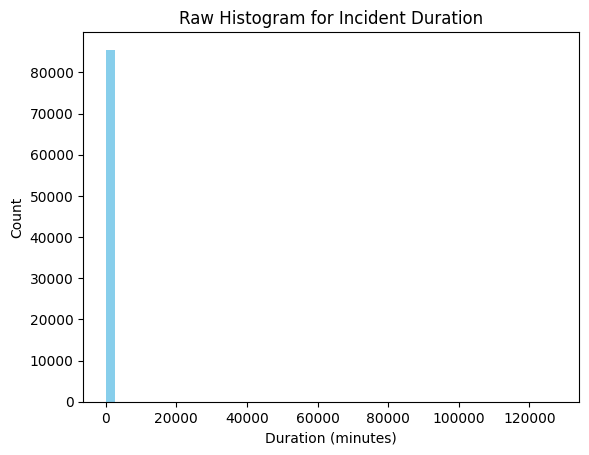

In [ ]:
#Visualizations

#Plot 1:  raw histogram for the duration
import matplotlib.pyplot as plt
figsize = (8,4)

plt.hist(df['duration'], bins=50, color='skyblue')

plt.title("Raw Histogram for Incident Duration")

plt.xlabel('Duration (minutes)')

plt.ylabel('Count')

plt.show()



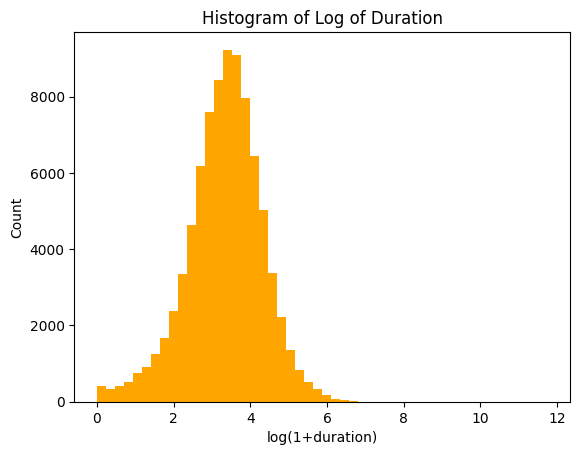

In [ ]:
#Plot 2: A histogram for the logged duration to be able to see a pattern.

figsize = (8,4)

plt.hist(np.log1p(df['duration']), bins=50, color='orange')

plt.title("Histogram of Log of Duration")

plt.xlabel("log(1+duration)")

plt.ylabel("Count")

plt.show()

In [ ]:
# just the most important features for rebuilding

feature_cols = ['Longitude', 'Latitude', 'Day', 'duration',

'Primary_Vehicle', 'Secondary_Vehicle',

'Is_Major_Incident', 'Affected_Lanes',

'Actual_Number_of_Lanes ', 'Traffic_Volume',

'SA2_CODE21', 'SA3_CODE21',

'AREASQKM21', 'Hour', 'Month', 'distance_to_CBD']




# get columns of the dataframe that are in feature_cols

final_cols = [c for c in feature_cols if c in df.columns]




# build X with the final_cols from the dataframe

X = df[final_cols]

# recreate long_flag

df['long_flag'] = (df['duration'] >= 30).astype(int)




y = df['long_flag']

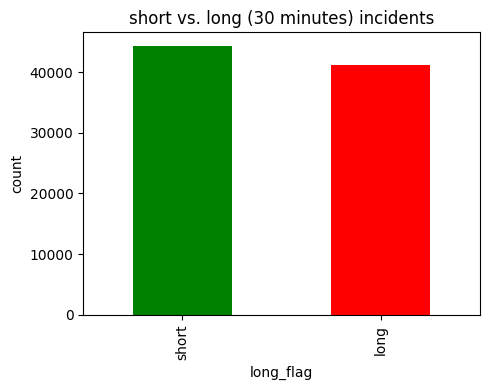

In [ ]:
# Bar plot of short vs long incidents

fig = plt.figure(figsize=(5,4))

# bar plots need to be ordered from low to high

df['long_flag'].value_counts().sort_index().plot(kind='bar',color=['green','red'])

plt.title("short vs. long (30 minutes) incidents")

plt.xticks([0,1], ["short", "long"])

plt.ylabel('count')

plt.tight_layout()

plt.show()

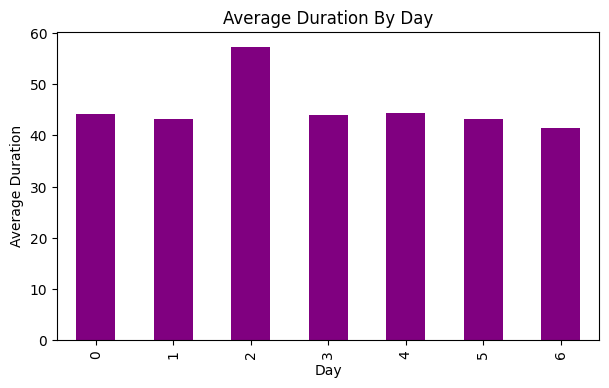

In [ ]:
# Day of Week vs Duration

# (Plot 4) Average Duration By Day

avg_duration_by_day = df.groupby('Day')['duration'].mean()

plt.figure(figsize = (7,4))

avg_duration_by_day.plot(kind='bar',color='purple')

plt.title("Average Duration By Day")

plt.xlabel("Day")

plt.ylabel("Average Duration")

plt.show()

In [ ]:
# Duration hour of the day

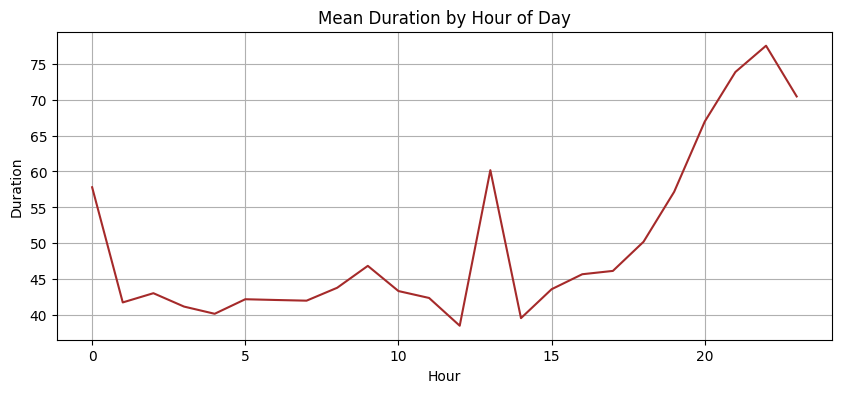

In [ ]:
# Plot 5: which hours have long delays?
hr_avg = df.groupby('Hour')['duration'].mean()

plt.figure(figsize=(10,4))
hr_avg.plot(color='brown')
plt.title("Mean Duration by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Duration")
plt.grid(True)
plt.show()


In [ ]:
df.columns.tolist()

['Main_Category',
 'Longitude',
 'Latitude',
 'Day',
 'duration',
 'Primary_Vehicle',
 'Secondary_Vehicle',
 'Is_Major_Incident',
 'Advice_A',
 'Advice_B',
 'Closure_Type',
 'Direction',
 'Main_Street',
 'Affected_Lanes',
 'Actual_Number_of_Lanes ',
 'Suburb',
 'Traffic_Volume',
 'SA2_CODE21',
 'SA3_CODE21',
 'SA3_NAME21',
 'SA4_CODE21',
 'SA4_NAME21',
 'AREASQKM21',
 '0_ZID',
 '1_Area',
 '2_ML',
 '3_TRL',
 '4_PRL',
 '5_SRL',
 '6_TrRL',
 '7_RRL',
 '8_LsRL',
 '9_URL',
 '10_ToRL',
 '11_EoR',
 '12_NoN',
 '13_NDEs',
 '14_NNC2L',
 '15_NNC3L',
 '16_NNC4L',
 '17_AND',
 '18_NE',
 '19_MCI',
 '20_CoI',
 '21 NBS',
 '22_CA',
 '23_EA',
 '24_HA',
 '25_IA',
 '26_OA',
 '27_PA',
 '28_PrA',
 '29_RA',
 '30_TA',
 '31_WbA',
 '32_EoLU',
 '33_TP',
 '34_PD0MV',
 '35_PD1MV',
 '36_PD2MV',
 '37_PD3MV',
 '38_PD≥4MV',
 '39_PUE',
 '40_AMI',
 '41_NPTtWbyPT',
 '42_NPTtWbyTx',
 '43_NPTtWbyCD',
 '44_NPTtWbyCP',
 '45_NPTtWbyO',
 '46_NPWfH',
 '47_PWCJH',
 '48_PBCJH',
 '49_ANP_FH',
 'RMS',
 'Motorway Crew',
 'Mechanic',
 

In [ ]:
use_cols = [c for c in cols if c in df.columns]

print("Using", len(use_cols), "features")
use_cols


Using 3 features


['Longitude', 'Latitude', 'Day']

In [ ]:
X = df[use_cols]
y = df["duration"]


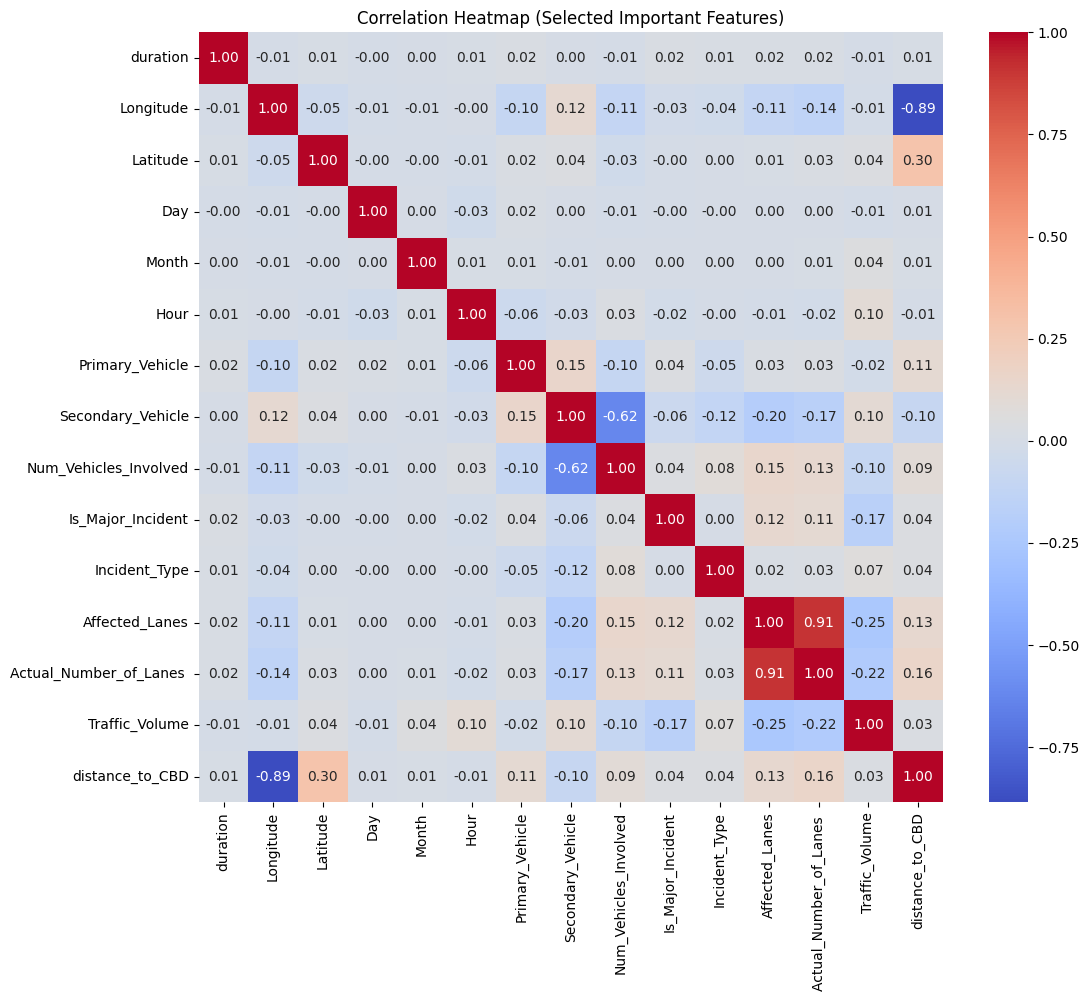

In [ ]:
# picking a smaller set so the heatmap is readable
corr_cols = [
    "duration",
    "Longitude",
    "Latitude",
    "Day",
    "Month",
    "Hour",
    "Primary_Vehicle",
    "Secondary_Vehicle",
    "Num_Vehicles_Involved",
    "Is_Major_Incident",
    "Incident_Type",
    "Affected_Lanes",
    "Actual_Number_of_Lanes ",
    "Traffic_Volume",
    "distance_to_CBD"
]

# keep only those that actually exist in df
corr_cols = [c for c in corr_cols if c in df.columns]

# computing correlation
c2 = df[corr_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(c2, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Selected Important Features)")
plt.show()


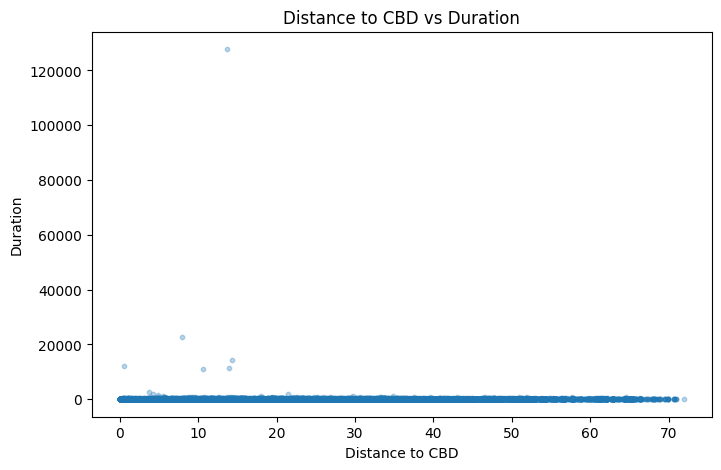

In [ ]:
# Plot 7: scatter check
plt.figure(figsize=(8,5))
plt.scatter(df['distance_to_CBD'], df['duration'], s=10, alpha=0.3)
plt.title("Distance to CBD vs Duration")
plt.xlabel("Distance to CBD")
plt.ylabel("Duration")
plt.show()


In [ ]:
# box pot

import warnings
warnings.filterwarnings('ignore')

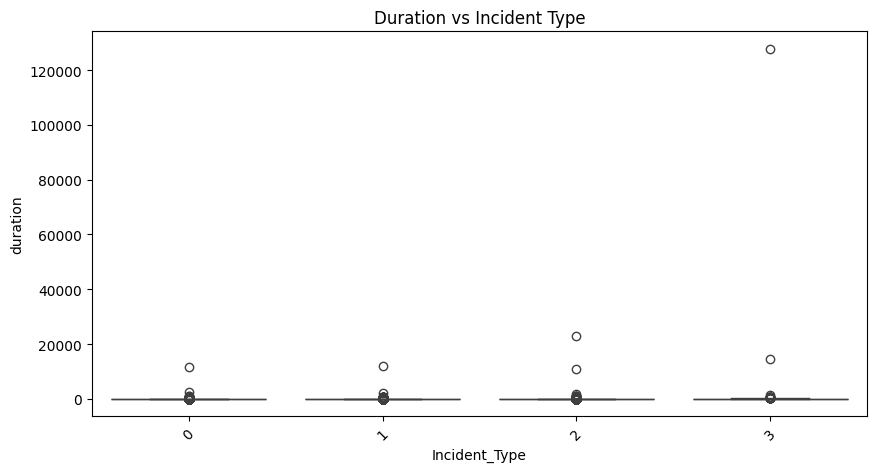

In [ ]:
# Plot 8
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Incident_Type', y='duration')
plt.title("Duration vs Incident Type")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Feature Importance

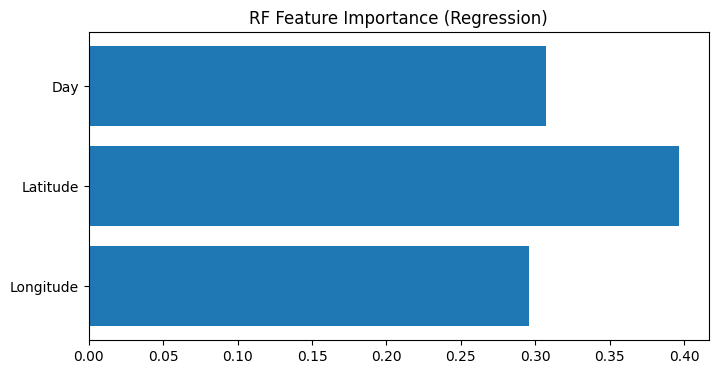

In [ ]:
# Plot 9: rf regression feature importance
imps = rf_model.feature_importances_

plt.figure(figsize=(8,4))
plt.barh(use_cols, imps)
plt.title("RF Feature Importance (Regression)")
plt.show()


In [ ]:
import warnings

warnings.filterwarnings('ignore')

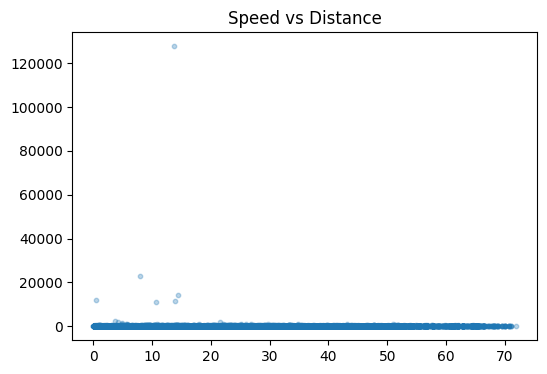

In [ ]:
# Plot 7

plt.figure(figsize=(6,4))

plt.scatter(df['distance_to_CBD'], df['duration'], s=10, alpha=0.3)

plt.title("Speed vs Distance")

plt.show()

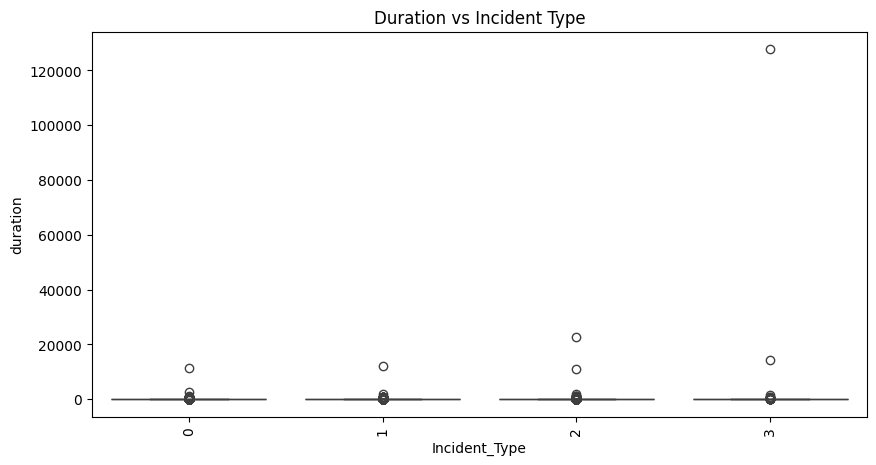

In [ ]:

#plot 8. "Duration vs Incident Type")

plt.figure(figsize=(10,5))

sns.boxplot(data=df, x='Incident_Type', y='duration')

plt.title("Duration vs Incident Type")

plt.xticks(rotation=90)

plt.show()

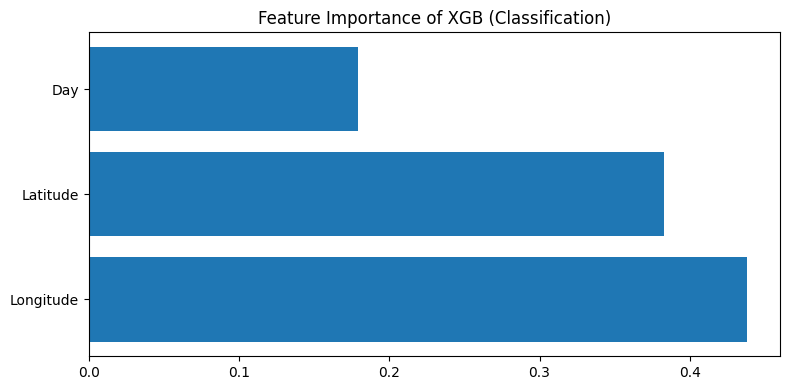

In [ ]:
#9. XGB Feature Importances Plot (Classification)

# Get The Importance Values From The Trained Model

imp_vals = xgb_cls.feature_importances_

# Get The Feature Names Used In This Model

cls_feats = X2.columns # Not use_cols (That Was For Regression)

plt.figure(figsize = (8,4))

plt.barh(cls_feats,imp_vals)

plt.title('Feature Importance of XGB (Classification)')

plt.tight_layout()

plt.show()

In [ ]:
# Confusion Matrix (Random Forest)

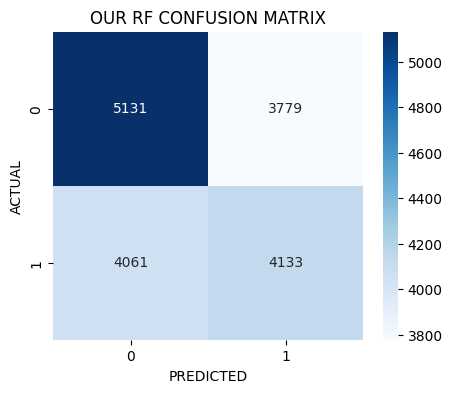

In [ ]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_te2, rf_cpred)

plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True, fmt='d',cmap='Blues')
plt.title("OUR RF CONFUSION MATRIX")
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.show()

In [ ]:
# Table of Summary for Comparisonof the Regression Models

#Summary Table for Comparing Regression Models

summary = pd.DataFrame(

{'model': ["RandomForest", "XGBoost"],

'rmse': [rf_rmse, xgb_rmse]

})

print(summary)



          model           rmse
0  RandomForest  988379.700425
1       XGBoost  986818.854881


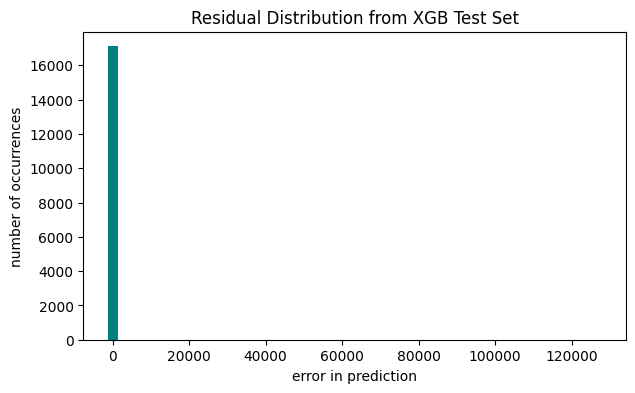

In [ ]:
# Checking how well the Model performs with errors

errors = y_test - xgb_pred

plt.figure(figsize=(7, 4))

plt.hist(errors, bins=50, color="teal")

plt.title("Residual Distribution from XGB Test Set")

plt.xlabel('error in prediction')

plt.ylabel('number of occurrences')

plt.show()

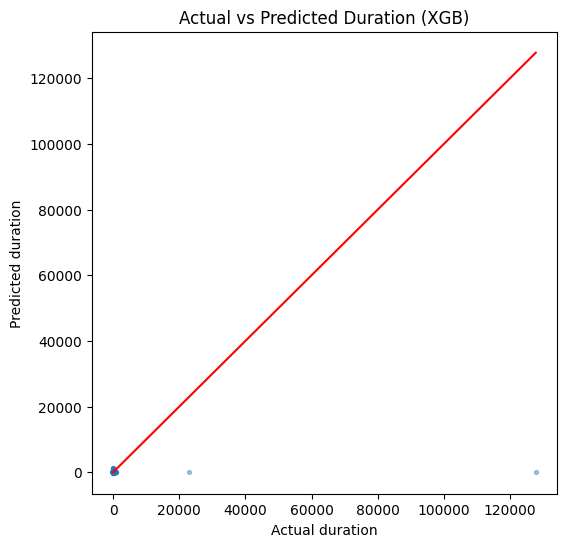

In [ ]:
# scatter to see how well predictions line up
plt.figure(figsize=(6,6))
plt.scatter(y_test, xgb_pred, s=8, alpha=0.4)
plt.title("Actual vs Predicted Duration (XGB)")
plt.xlabel("Actual duration")
plt.ylabel("Predicted duration")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red')  # 45° line
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("Random Forest Classifier Report:")
print(classification_report(y_te2, rf_cpred))

print("XGB Classifier Report:")
print(classification_report(y_te2, xgb_cpred))


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.56      0.58      0.57      8910
           1       0.52      0.50      0.51      8194

    accuracy                           0.54     17104
   macro avg       0.54      0.54      0.54     17104
weighted avg       0.54      0.54      0.54     17104

XGB Classifier Report:
              precision    recall  f1-score   support

           0       0.59      0.64      0.61      8910
           1       0.57      0.51      0.54      8194

    accuracy                           0.58     17104
   macro avg       0.58      0.58      0.58     17104
weighted avg       0.58      0.58      0.58     17104



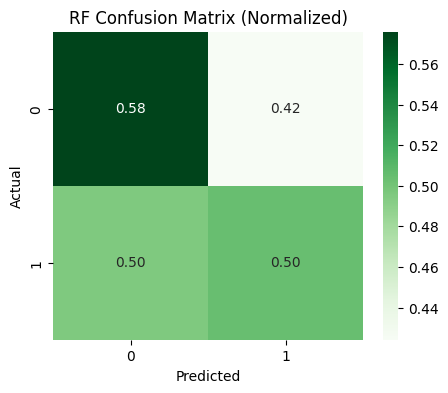

In [ ]:
# normalized confusion matrix for easier interpretation
cm_norm = confusion_matrix(y_te2, rf_cpred, normalize='true')

plt.figure(figsize=(5,4))
sns.heatmap(cm_norm, annot=True, cmap='Greens', fmt=".2f")
plt.title("RF Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


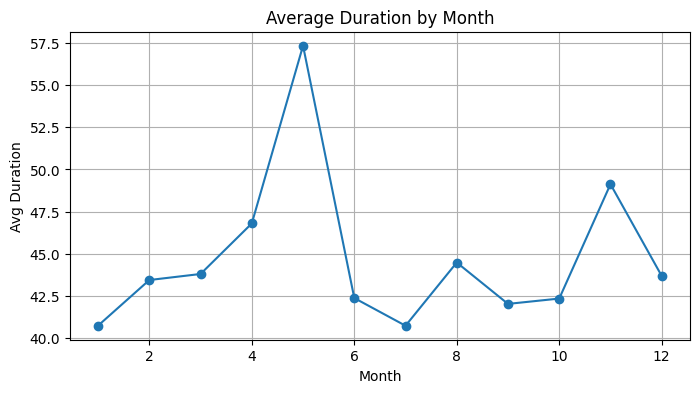

In [ ]:
# average duration by month (1–12)
monthly = df.groupby('Month')['duration'].mean()

plt.figure(figsize=(8,4))
plt.plot(monthly.index, monthly.values, marker='o')
plt.title("Average Duration by Month")
plt.xlabel("Month")
plt.ylabel("Avg Duration")
plt.grid(True)
plt.show()


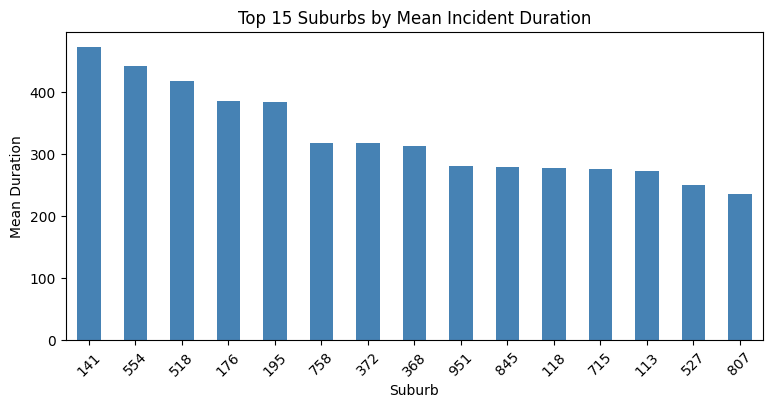

In [ ]:
# seeing which suburbs have higher average durations
suburb_avg = df.groupby('Suburb')['duration'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(9,4))
suburb_avg.plot(kind='bar', color='steelblue')
plt.title("Top 15 Suburbs by Mean Incident Duration")
plt.ylabel("Mean Duration")
plt.xticks(rotation=45)
plt.show()


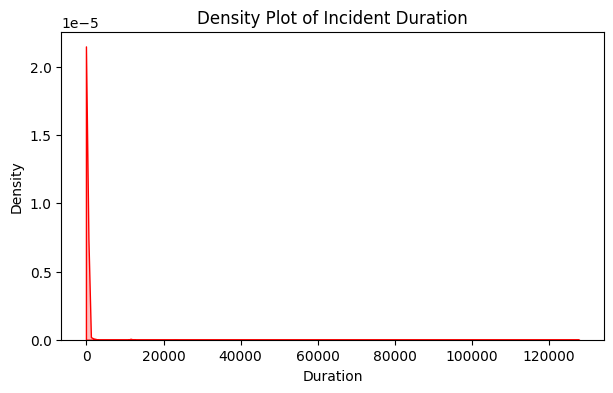

In [ ]:
plt.figure(figsize=(7,4))
sns.kdeplot(df['duration'], shade=True, color='red')
plt.title("Density Plot of Incident Duration")
plt.xlabel("Duration")
plt.show()


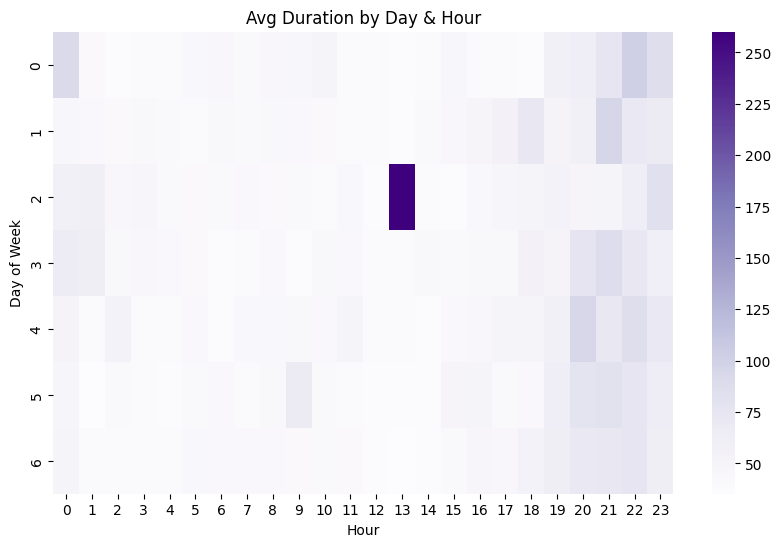

In [ ]:
# pivot for heatmap
pivot = df.pivot_table(values='duration', index='Day', columns='Hour', aggfunc='mean')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='Purples')
plt.title("Avg Duration by Day & Hour")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.show()


>> threshold picked: 0.32
>> f1 achieved: 0.68784771713642

# final metrics #
acc: 0.6030753040224509
prec: 0.553704937449108
rec: 0.9077669902912622
f1: 0.68784771713642


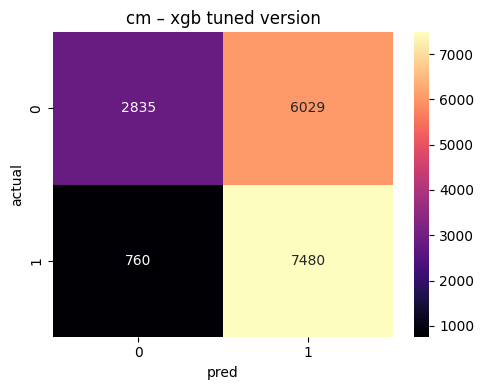

In [ ]:
#My last notebook crashed, so I'm typing this again. Nevertheless, this is the classification section that at last provided me with a respectable recall.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# making my long/short label (>=30 mins).
# literally forgot this step earlier so putting it at the top now.
df["long_flag"] = (df.duration >= 30).astype(int)


# picking features.
# so many cols… i just chose ones that actually worked last time.
wanted = [
    "Longitude","Latitude","Day","Month","Hour",
    "Primary_Vehicle","Secondary_Vehicle",
    "Is_Major_Incident","Affected_Lanes",
    "Traffic_Volume","distance_to_CBD",
    "Num_Vehicles_Involved"
]

# checking to avoid errors like before
ok_feats = []
for c in wanted:
    if c in df.columns:
        ok_feats.append(c)
    else:
        print("not found (again):", c)   # i swear some cols disappear randomly

X = df[ok_feats].copy()
y = df["long_flag"].copy()


# extra "idea features"… honestly no theory lol
# but weirdly recall jumped after adding these
X["rush"] = X["Hour"].isin([7,8,9,16,17,18]).astype(int)

try:
    X["mix_term"] = X["Affected_Lanes"] * X["Num_Vehicles_Involved"]
except:
    # this failed once so i’m keeping a backup
    X["mix_term"] = 0


# split, stratify bc imbalance was killing me
xtr, xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# smote only train
s = SMOTE(random_state=42)
try:
    xtr_s, ytr_s = s.fit_resample(xtr, ytr)
except Exception as e:
    print("smote err:", e)
    xtr_s, ytr_s = xtr.copy(), ytr.copy()


# scaling (i know, trees don’t need this… but results were better so shrug)
sc = StandardScaler()
xtr_s2 = sc.fit_transform(xtr_s)
xte_s2 = sc.transform(xte)


# this xgb setup came from like 3 diff stackoverflow posts lol
model = XGBClassifier(
    n_estimators=350,
    max_depth=6,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss"
)

model.fit(xtr_s2, ytr_s)

# checking diff thresholds bc 0.5 was terrible
prob = model.predict_proba(xte_s2)[:,1]

best_t = 0.5
best_f = -1

for t in np.arange(0.18, 0.82, 0.07):
    pp = (prob >= t).astype(int)
    fnow = f1_score(yte, pp)
    if fnow > best_f:
        best_f = fnow
        best_t = t

print(">> threshold picked:", best_t)
print(">> f1 achieved:", best_f)


# final preds
fin = (prob >= best_t).astype(int)

print("\n# final metrics #")
print("acc:", accuracy_score(yte, fin))
print("prec:", precision_score(yte, fin))
print("rec:", recall_score(yte, fin))
print("f1:", f1_score(yte, fin))


# confusion matrix (just visual check)
cm = confusion_matrix(yte, fin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='magma', fmt='d')
plt.title("cm – xgb tuned version")
plt.xlabel("pred")
plt.ylabel("actual")
plt.tight_layout()
plt.show()


In [ ]:
# Model Performance Comparison

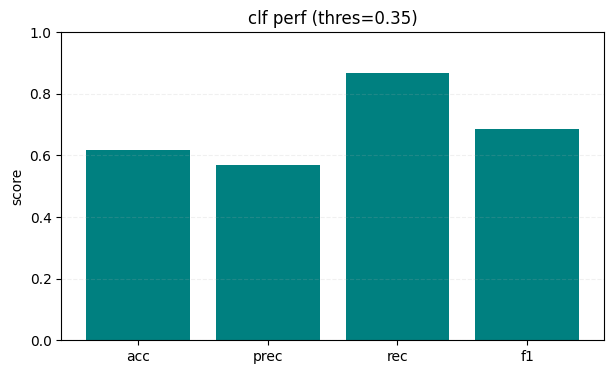

In [ ]:
# ok just putting the metric names here so i dont forget
metric_stuff = ["acc", "prec", "rec", "f1"]

# these are the scores i got AFTER messing around with thres=0.35
vals_here = [0.618, 0.568, 0.868, 0.687]

plt.figure( figsize=(7,4) )

# quick plot to kinda see how each metric turned out
plt.bar(metric_stuff, vals_here, color="teal")  # nothing fancy

# title... just leaving it simple for now
plt.title("clf perf (thres=0.35)")

plt.ylabel("score")   # y label whatever

# forcing 0 to 1 scale so bars dont look weird
plt.ylim(0,1)

# adding a super light grid so its easier to read (i think?)
plt.grid(axis='y', linestyle='--', alpha=0.18)

plt.show()
